# Aircraft performance

- Authors: Roger Teoh
- Date: 2023-04-15
- `pycontrails`: v0.39.6

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/contrailcirrus/2023-04-pycontrails-workshop/blob/main/notebooks/XX-Geospatial.ipynb)

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install openap
!pip install pycontrails

In [ ]:
# GCP Bucket with sample data
GCP_BUCKET = "gs://2023-04-pycontrails-workshop"

# make data/ directory
!mkdir -p "data/flight/sample"

# sync sample flight files
!gsutil -m rsync -r "{GCP_BUCKET}/data/flight/sample" "data/flight/sample"

In [ ]:
import pandas as pd
import numpy as np
from pycontrails import Flight
from pycontrails.physics import units

In [ ]:
# Load all sample flights
waypoints = pd.read_parquet("data/flight/sample/waypoints.pq")

# Select one flight
flight_id = "200101-46388-SIA308"
df_flight = waypoints.loc[waypoints["flight_id"] == flight_id]

In [ ]:
# Cruise only (filter for waypoints > 30,000 feet and minimal change in altitude)
d_altitude = np.diff(df_flight["altitude_ft"].values, append=np.nan)
df_flight = df_flight.loc[(df_flight["altitude_ft"] > 30000) & (d_altitude <= 25)]

# Assume ISA temperature 
df_flight["air_temperature"] = units.m_to_T_isa(units.ft_to_m(df_flight["altitude_ft"]))
df_flight["specific_humidity"] = 0.0

In [ ]:
# Instantiate flight object
flight = Flight(df_flight, flight_id=flight_id, aircraft_type="A388")
flight

In [ ]:
# https://openap.dev/usage
from openap import prop

# Get aircraft properties
aircraft = prop.aircraft("A388")
aircraft

{'aircraft': 'Airbus A380-800',
 'fuselage': {'length': 72.72, 'height': 8.41, 'width': 7.14},
 'wing': {'area': 845, 'span': 79.75, 'mac': None, 'sweep': 33.5, 't/c': 0.08},
 'flaps': {'type': 'single-slotted', 'area': None, 'bf/b': None},
 'limits': {'MTOW': 560000,
  'MLW': 386000,
  'OEW': 277000,
  'MFC': 320000,
  'VMO': 340,
  'MMO': 0.89,
  'ceiling': 13100},
 'cruise': {'height': 12800, 'mach': 0.85},
 'engine': {'type': 'turbofan',
  'mount': 'wing',
  'number': 4,
  'default': 'GP7270',
  'options': {'A380-841': 'Trent 970-84',
   'A380-842': 'Trent 972-84',
   'A380-861': 'GP7270'}}}

In [ ]:
# Get engine properties
engine = prop.engine("Trent 970-84")
engine

{'uid': '18RR081',
 'name': 'Trent 970-84',
 'manufacturer': 'Rolls-Royce plc',
 'type': 'TF',
 'bpr': 8.45,
 'pr': 38.0,
 'max_thrust': 338700,
 'ei_hc_to': 0.02,
 'ei_hc_co': 0.12,
 'ei_hc_app': 0.08,
 'ei_hc_idl': 0.04,
 'ei_co_to': 0.32,
 'ei_co_co': 0.31,
 'ei_co_app': 1.16,
 'ei_co_idl': 13.38,
 'ei_nox_to': 38.29,
 'ei_nox_co': 29.42,
 'ei_nox_app': 12.09,
 'ei_nox_idl': 5.44,
 'ff_to': 2.605,
 'ff_co': 2.157,
 'ff_app': 0.72,
 'ff_idl': 0.255,
 'fuel_lto': 965.0,
 'fuel_c3': -0.240299,
 'fuel_c2': 1.05084,
 'fuel_c1': 1.66078,
 'fuel_a': 1.30706,
 'fuel_b': 0.421769,
 'cruise_thrust': nan,
 'cruise_sfc': nan,
 'cruise_mach': nan,
 'cruise_alt': nan,
 'fuel_ch': 6.7e-07}

In [ ]:
# Calculate fuel flow: https://openap.dev/emission 
from openap import FuelFlow

fuelflow = FuelFlow(ac='A388', eng='Trent 970-84')
ff_cruise = fuelflow.enroute(mass=flight["aircraft_mass"], tas=unit.m_per_s_to_knots(flight["true_airspeed"]), alt=flight["altitude_ft"], path_angle=0)
ff_cruise

array([4.25069462, 4.2451446 , 4.23985146, ..., 3.48280415, 3.48230601,
       3.4818292 ])

(2.558076411066796, 4.3148535042349145)

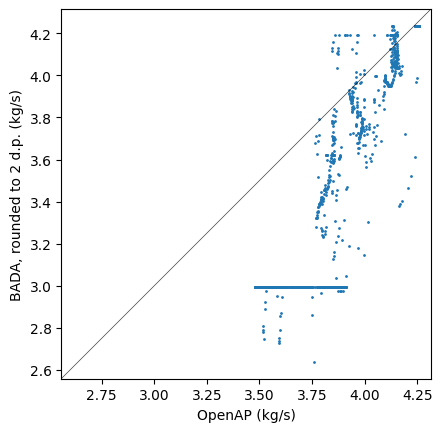

In [ ]:
# Compare fuel flow estimates: OpenAP vs. BADA (rounded to 2 d.p.)
import matplotlib.pyplot as plt

f, ax = plt.subplots()
plt.scatter(ff_cruise, flight["fuel_flow"], s=1)
plt.xlabel("OpenAP (kg/s)")
plt.ylabel("BADA, rounded to 2 d.p. (kg/s)")
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k-', alpha=0.75, linewidth=0.5)
ax.set_aspect('equal');
ax.set_xlim(lims);
ax.set_ylim(lims);

# BADA accounts for acceleration/deceleration between waypoints

In [ ]:
# Calculate overall propulsion efficiency (OPE) using OpenAP
from pycontrails.physics.jet import overall_propulsion_efficiency
from openap import Drag

# Assume drag = thrust as waypoints are filtered for cruise phase 
drag = Drag(ac='A388', eng='Trent 970-84')
f_thrust = drag.clean(mass=flight["aircraft_mass"], tas=units.m_per_s_to_knots(flight["true_airspeed"]), alt=flight["altitude_ft"], path_angle=0)

ope = overall_propulsion_efficiency(flight["true_airspeed"], f_thrust, flight["fuel_flow"], q_fuel=43.2e6, is_descent=None)

(0.3256085133635274, 0.5083043565064987)

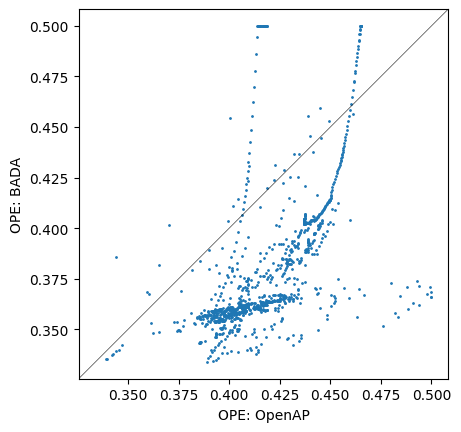

In [ ]:
f, ax = plt.subplots()
plt.scatter(ope, flight["engine_efficiency"], s=1)
plt.xlabel("OPE: OpenAP")
plt.ylabel("OPE: BADA")
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k-', alpha=0.75, linewidth=0.5)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

In [ ]:
# Calculate emissions using OpenAP: https://openap.dev/emission

# NOTE: No nvPM emissions
from openap import Emission

emission_openap = Emission(ac='A388', eng='Trent 970-84')
co2 = emission_openap.co2(ff_cruise)
nox = emission_openap.nox(ff_cruise, tas=units.m_per_s_to_knots(flight["true_airspeed"]), alt=flight["altitude_ft"])
nox

array([86.82786636, 86.56464249, 86.31196529, ..., 64.03360415,
       64.01962628, 64.00660815])

In [ ]:
# Calculate emissions using pycontrails
from pycontrails.models.emissions import Emissions

# Attach additional flight properties
flight.attrs["engine_uid"] = "01P18RR103"
flight.attrs["n_engine"] = 4

# Instantiate emissions class
emissions = Emissions(copy_source=False)

flight = emissions.eval(source=flight)

In [ ]:
flight["nvpm_ei_n"]

array([4.13338176e+14, 4.17637011e+14, 3.34075253e+14, ...,
       5.71571912e+14, 5.70251565e+14, 5.69004166e+14])